### 1. You are required to restore the image with mixing texture (IMG_1.png). It is supposed that you decide to use Fourier transform to remove the texture out of the image. Write a function to do it (built-in fft and ifft are permitted). (3 marks)

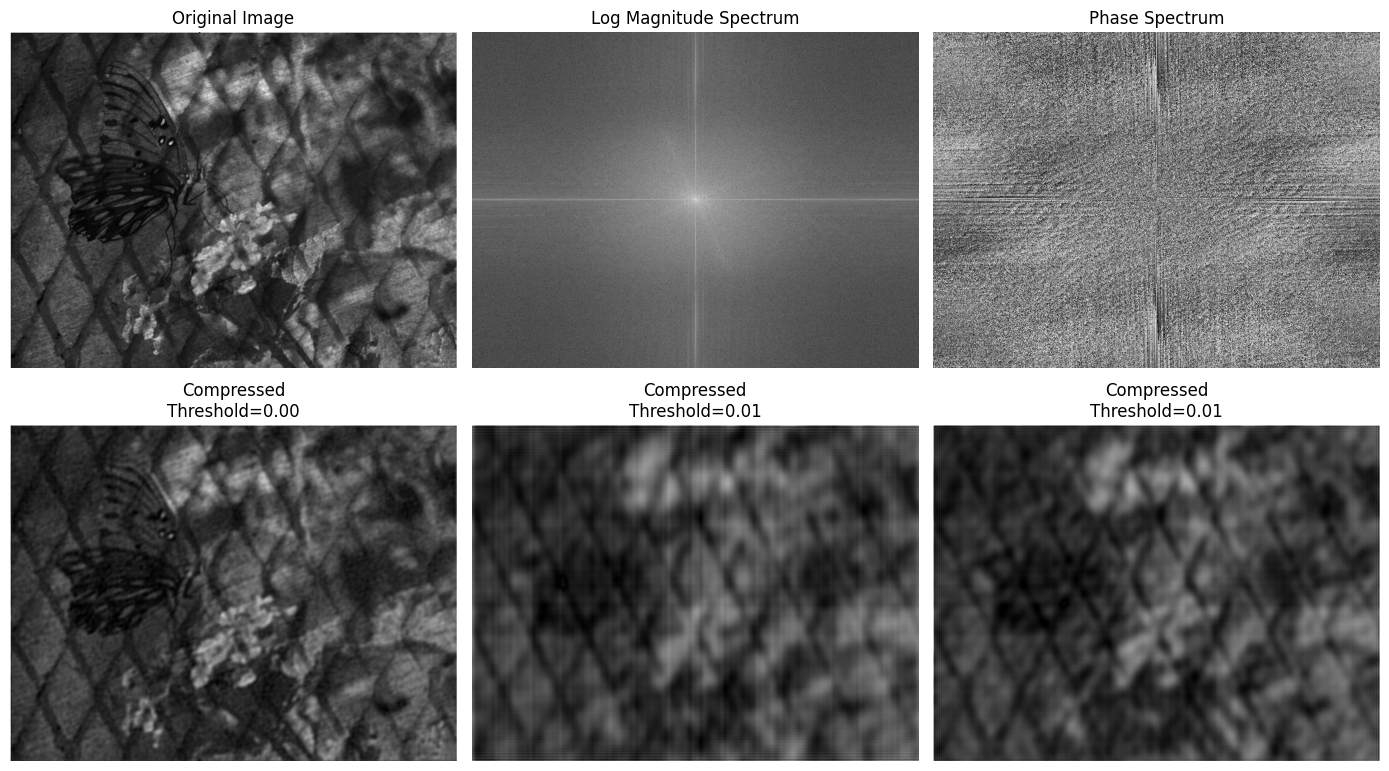

In [5]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread(r'D:\Gitrepo\CPV\IMG_1.png', cv.IMREAD_GRAYSCALE)
assert img is not None

# Step 1: FFT (frequency domain)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

# Step 2: Extract magnitude and phase
magnitude = np.abs(fshift)
phase = np.angle(fshift)

# Step 3: Use three thresholds for (2,3) grid
threshold_list = [0.001, 0.0075, 0.005]  # as fractions of max(magnitude)

plt.figure(figsize=(14, 8))

# (row 1, col 1): Original image
plt.subplot(2, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# (row 1, col 2): Log Magnitude Spectrum
plt.subplot(2, 3, 2)
plt.imshow(np.log1p(magnitude), cmap='gray')
plt.title('Log Magnitude Spectrum')
plt.axis('off')

# (row 1, col 3): Empty or you can show the phase spectrum
plt.subplot(2, 3, 3)
plt.imshow(phase, cmap='gray')
plt.title('Phase Spectrum')
plt.axis('off')

# Row 2: Compressed images for each threshold
for idx, frac in enumerate(threshold_list):
    threshold = frac * np.max(magnitude)
    mask = magnitude > threshold
    fshift_compressed = fshift * mask

    # Step 4: Reconstruct image using IFFT
    f_ishift = np.fft.ifftshift(fshift_compressed)
    img_compressed = np.fft.ifft2(f_ishift)
    img_compressed = np.abs(img_compressed)
    img_compressed = np.clip(img_compressed, 0, 255).astype(np.uint8)

    plt.subplot(2, 3, idx+4)
    plt.imshow(img_compressed, cmap='gray')
    plt.title(f'Compressed\nThreshold={frac:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### 2. A customer requires you to stitch 4 images (IMG_2a.jpg, IMG_2b.jpg, IMG_2c.jpg, IMG_2d.jpg) to generate a panorama image. Write a function which uses stitching techniques to combine them into a larger picture. (2 marks)

In [6]:
def stitch_images(image_paths):
    # Load images
    images = []
    for path in image_paths:
        img = cv.imread(path)
        if img is not None:
            images.append(img)

	# Convert all images to same color space
    processed_images = []
    for img in images:
		# Normalize lighting using histogram equalization
        lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)
        lab[:,:,0] = cv.equalizeHist(lab[:,:,0])
        normalized = cv.cvtColor(lab, cv.COLOR_LAB2BGR)
        processed_images.append(normalized)

    # Initialize SIFT detector
    sift = cv.SIFT_create()
    
    # Start with the first image as base
    result = processed_images[0]
    
    # Stitch each subsequent image to the result
    for i in range(1, len(processed_images)):
        current_img = processed_images[i]
        
        # Convert to grayscale for feature detection
        gray1 = cv.cvtColor(result, cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(current_img, cv.COLOR_BGR2GRAY)
        
        # Detect keypoints and descriptors
        kp1, des1 = sift.detectAndCompute(gray1, None)
        kp2, des2 = sift.detectAndCompute(gray2, None)
        
        if des1 is None or des2 is None:
            print(f"No features found in image {i}")
            continue
        
        # Match features using FLANN matcher
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        
        matches = flann.knnMatch(des1, des2, k=2)
        
        # Apply Lowe's ratio test to filter good matches
        good_matches = []
        for match_pair in matches:
            if len(match_pair) == 2:
                m, n = match_pair
                if m.distance < 0.7 * n.distance:
                    good_matches.append(m)
        
        # Extract matched keypoints
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Find homography using RANSAC
        M, mask = cv.findHomography(dst_pts, src_pts, cv.RANSAC, 5.0)
        
        # Get dimensions for the output image
        h1, w1 = result.shape[:2]
        h2, w2 = current_img.shape[:2]
        
        # Transform corners of current image to find output size
        corners2 = np.float32([[0, 0], [w2, 0], [w2, h2], [0, h2]]).reshape(-1, 1, 2)
        transformed_corners = cv.perspectiveTransform(corners2, M)
        
        # Find bounding box of the stitched image
        all_corners = np.concatenate([
            np.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]]).reshape(-1, 1, 2),
            transformed_corners
        ])
        
        [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
        [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
        
        # Create translation matrix to handle negative coordinates
        translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float32)
        
        # Apply translation to homography
        M = translation @ M
        
        # Calculate output size
        output_width = x_max - x_min
        output_height = y_max - y_min
        
        # Warp current image
        warped = cv.warpPerspective(current_img, M, (output_width, output_height))
        
        # Create a copy of result image with proper size and position
        result_translated = np.zeros((output_height, output_width, 3), dtype=np.uint8)
        result_translated[-y_min:-y_min+h1, -x_min:-x_min+w1] = result
        
        # Create mask for blending
        mask_warped = np.zeros((output_height, output_width), dtype=np.uint8)
        mask_warped[warped[:,:,0] > 0] = 255
        
        mask_result = np.zeros((output_height, output_width), dtype=np.uint8)
        mask_result[-y_min:-y_min+h1, -x_min:-x_min+w1] = 255
        
        # Find overlapping region
        overlap = cv.bitwise_and(mask_warped, mask_result)
        
        # Simple blending: average in overlap region
        result_new = result_translated.copy()
        
        # Where only warped image exists
        only_warped = cv.bitwise_and(mask_warped, cv.bitwise_not(mask_result))
        result_new[only_warped > 0] = warped[only_warped > 0]
        
        # Where both images exist (overlap), blend them
        if np.any(overlap > 0):
            overlap_coords = np.where(overlap > 0)
            result_new[overlap_coords] = (
                result_translated[overlap_coords].astype(np.float32) * 0.5 + 
                warped[overlap_coords].astype(np.float32) * 0.5
            ).astype(np.uint8)
        
        result = result_new
    
    return result

# Load and stitch the 4 images
image_paths = [
    r'D:\Gitrepo\CPV\IMG_2a.jpg',
    r'D:\Gitrepo\CPV\IMG_2b.jpg', 
    r'D:\Gitrepo\CPV\IMG_2c.jpg',
    r'D:\Gitrepo\CPV\IMG_2d.jpg'
]

panorama = stitch_images(image_paths)

# Display the result
plt.figure(figsize=(20, 10))
plt.imshow(cv.cvtColor(panorama, cv.COLOR_BGR2RGB))
plt.title('Panorama Image')
plt.axis('off')
plt.show()


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 15280251840 bytes in function 'cv::OutOfMemoryError'


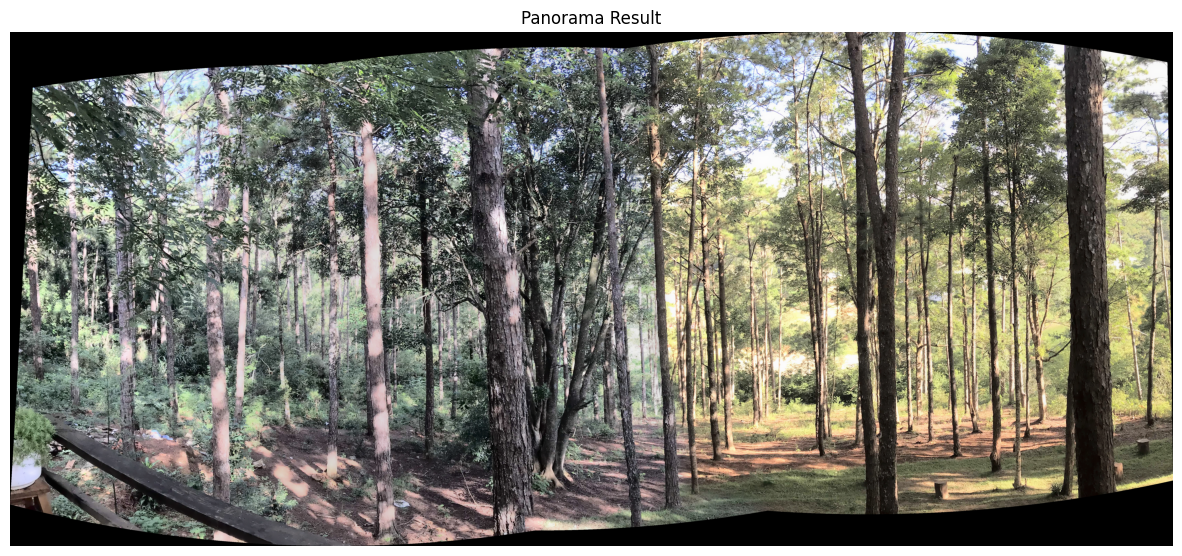

In [ ]:
def stitch_images_simple(image_paths):
	images = []
	for path in image_paths:
		img = cv.imread(path)
		if img is not None:
			images.append(img)

	# Convert all images to same color space
	processed_images = []
	for img in images:
		# Normalize lighting using histogram equalization
		lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)
		lab[:,:,0] = cv.equalizeHist(lab[:,:,0])
		normalized = cv.cvtColor(lab, cv.COLOR_LAB2BGR)
		processed_images.append(normalized)
  
	# Use OpenCV's built-in stitcher
	stitcher = cv.Stitcher.create()
	status, panorama = stitcher.stitch(processed_images)
	
	if status == cv.Stitcher_OK:
		return panorama
	else:
		print(f"Stitching failed with status: {status}")
		return None

# Test the simpler approach
panorama_simple = stitch_images_simple(image_paths)

plt.figure(figsize=(15, 8))
plt.imshow(cv.cvtColor(panorama_simple, cv.COLOR_BGR2RGB))
plt.title('Panorama Result')
plt.axis('off')
plt.show()

### 3. You are required to segment the following image (IMG_3.png). You decide to use K-means to segment the image. However, you do not know how to select the best number K. One method is to compute the average difference between the segmented image and the original one in terms of intensity (pixel by pixel). Please write the function to calculate that average difference, then test with your segmented images using K=2 and K=3.

Origin Image

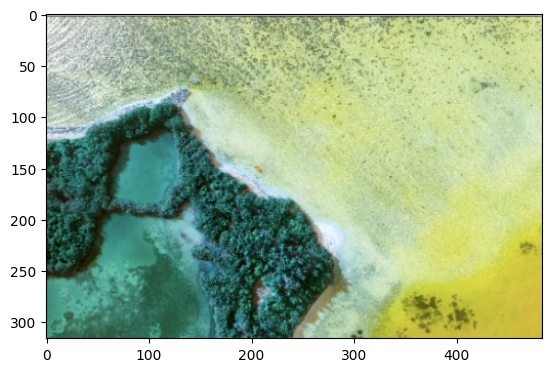

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('D:\Gitrepo\CPV\IMG_3.png')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

pixel_vals = image.reshape((-1,3))

pixel_vals = np.float32(pixel_vals)

K = 3 Image

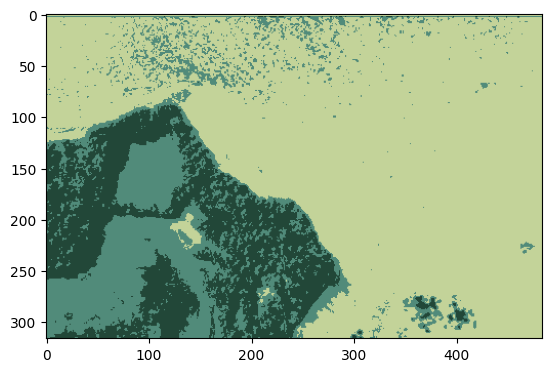

In [2]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

segmented_image = segmented_data.reshape((image.shape))

plt.imshow(segmented_image)

K = 2 Image

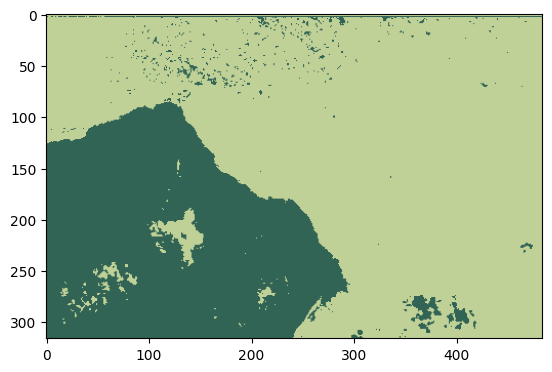

In [3]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

k = 2
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

segmented_image = segmented_data.reshape((image.shape))

plt.imshow(segmented_image)

### 4. The lighting in the following image (IMG_4.jpg) is insufficient, and the composition could be improved for better balance. You decide to balance it using the “gray world” method. Write a function to implement this method. (2 marks)

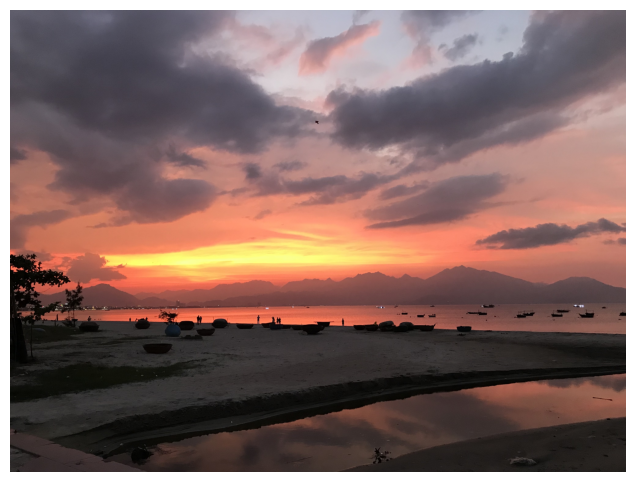

In [4]:
# Import necessary libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image using OpenCV
img = cv2.imread('D:\Gitrepo\CPV\IMG_4.jpg')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Display the image using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(rgb_img)
plt.axis('off')  # Hide axes
plt.show()

In [5]:
def gray_world_white_balance(img):
    # Calculate the avarage of each channel
    avg_b = np.mean(img[:, :, 0])
    avg_g = np.mean(img[:, :, 1])
    avg_r = np.mean(img[:, :, 2])

    # Calculate the overall average
    avg = (avg_b + avg_g + avg_r) / 3

    # Calculate the scaling factors for each channel
    scale_b = avg / avg_b
    scale_g = avg / avg_g
    scale_r = avg / avg_r

    # Apply the scaling factors to each channel
    balanced_img = np.zeros_like(img, dtype=np.float32)
    balanced_img[:, :, 0] = img[:, :, 0] * scale_b
    balanced_img[:, :, 1] = img[:, :, 1] * scale_g
    balanced_img[:, :, 2] = img[:, :, 2] * scale_r

    # Clip the values to be in the valid range [0, 255] and convert to uint8
    balanced_img = np.clip(balanced_img, 0, 255).astype(np.uint8)  

    return balanced_img


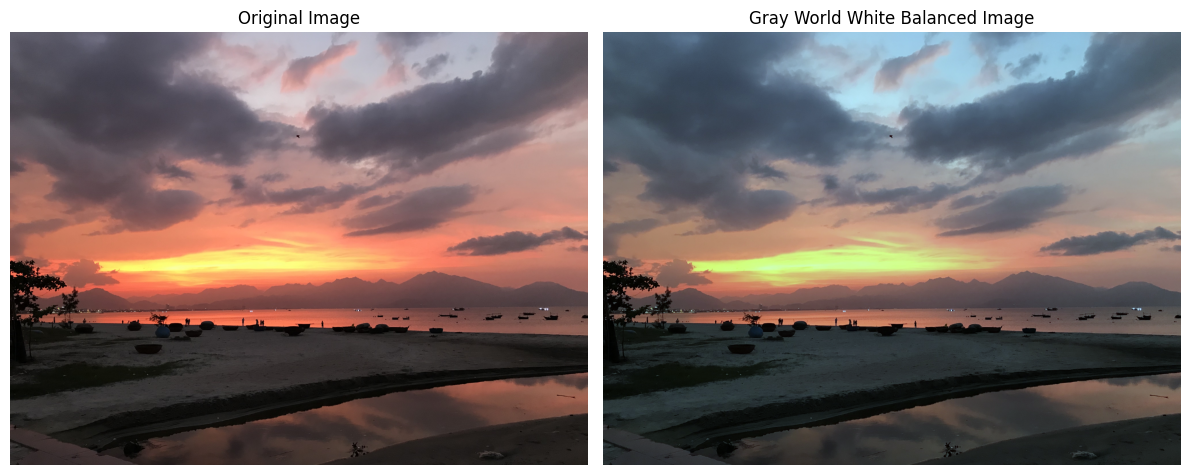

In [6]:
# Apply the Gray World white balancing
balanced_img = gray_world_white_balance(img)

# Convert both images from BGR to RGB for displaying with matplotlib
rgb_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rgb_balanced = cv2.cvtColor(balanced_img, cv2.COLOR_BGR2RGB)

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 6))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(rgb_original)
plt.title('Original Image')
plt.axis('off')  # Hide axes

# Display the white-balanced image
plt.subplot(1, 2, 2)
plt.imshow(rgb_balanced)
plt.title('Gray World White Balanced Image')
plt.axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()